In [5]:
import numpy as np
import pandas as pd
import os
from Bio import SeqIO
import itertools
from typing import List, Tuple
import string
from pathlib import Path
from tqdm.auto import tqdm, trange

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.kernel_ridge import KernelRidge

In [2]:
import torch
torch.cuda.is_available()

True

In [115]:
torch.hub.set_dir('/scratch/jlaw/torch')
model_name = "esm2_t36_3B_UR50D"
model, alphabet = torch.hub.load("facebookresearch/esm:main", model_name)

Using cache found in /scratch/jlaw/torch/facebookresearch_esm_main
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t48_15B_UR50D.pt" to /scratch/jlaw/torch/checkpoints/esm2_t48_15B_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t48_15B_UR50D-contact-regression.pt" to /scratch/jlaw/torch/checkpoints/esm2_t48_15B_UR50D-contact-regression.pt


### Build/get embeddings

In [11]:
def read_embeddings(embed_file, sequence_idx_file):
    """ Read embeddings stored in an npz file
    Get the sequences at each index from the *sequence_idx_file
    """
    embeddings = np.load(embed_file, allow_pickle=True)['arr_0']
    sequences = pd.read_csv(sequence_idx_file)
    print(f"{len(embeddings) = } read from {embed_file}")
    print(f"{len(sequences) = } read from {sequence_idx_file}")
    return embeddings, sequences

In [12]:
inputs_dir = Path("/projects/robustmicrob/jlaw/inputs/")

embeddings, df_seq = read_embeddings(Path(inputs_dir, "meltome/embeddings/20230125_embeddings_esm2_t33_650M_UR50D.npz"),
                                     Path(inputs_dir, "meltome/embeddings/20230125_embeddings_seqs.csv"))


len(embeddings) = 32563 read from /projects/robustmicrob/jlaw/inputs/meltome/embeddings/20230125_embeddings_esm2_t33_650M_UR50D.npz
len(sequences) = 32563 read from /projects/robustmicrob/jlaw/inputs/meltome/embeddings/20230125_embeddings_seqs.csv


In [13]:
embeddings

array([[ 0.0667  ,  0.0805  ,  0.02689 , ..., -0.05774 , -0.04825 ,
        -0.0274  ],
       [ 0.0723  ,  0.0428  ,  0.0324  , ..., -0.05963 , -0.02406 ,
        -0.01481 ],
       [-0.04813 , -0.04675 , -0.005882, ..., -0.1444  ,  0.02731 ,
         0.0689  ],
       ...,
       [ 0.03793 , -0.06665 ,  0.032   , ..., -0.1265  ,  0.04468 ,
         0.1527  ],
       [-0.01697 , -0.05865 ,  0.02788 , ..., -0.132   , -0.0846  ,
        -0.05984 ],
       [ 0.04132 , -0.08746 ,  0.006046, ..., -0.076   ,  0.03427 ,
         0.08185 ]], dtype=float16)

In [14]:
df_seq

,uniprot,Tm,sequence
0,A0A023T4K3,37.962947,MSGEEEKAADFYVRYYVGHKGKFGHEFLEFEFRPNGSLRYANNSNY...
1,A0A023T778,54.425342,MSMGSDFYLRYYVGHKGKFGHEFLEFEFRPDGKLRYANNSNYKNDV...
2,A0A061ACF5,49.459216,MRICFLLLAFLVAETFANELTRCCAGGTRHFKNSNTCSSIKSEGTS...
3,A0A061ACH4,42.593131,MIRVALPTTASAIPRSISTSPGETISKNHEEEVKRVWRKADAVCFD...
4,A0A061ACH8,37.999478,MNGDWSRAFVLSKVKNLYFFVIIDKGFSAILNDPREPVQVGGFFEV...
...,...,...,...
32558,Q9Y6X5,59.156044,MKLLVILLFSGLITGFRSDSSSSLPPKLLLVSFDGFRADYLKNYEF...
32559,Q9Y6X8,45.410797,MASKRKSTTPCMVRTSQVVEQDVPEEVDRAKEKGIGTPQPDVAKDS...
32560,Q9Y6X9,45.488338,MAFTNYSSLNRAQLTFEYLHTNSTTHEFLFGALAELVDNARDADAT...
32561,Q9Y6Y0,48.494270,MIPNGYLMFEDENFIESSVAKLNALRKSGQFCDVRLQVCGHEMLAH...


### Baseline: logisitic regression on sequence embeddings to predict tm values

In [22]:
# try using the same train/test splits that flip used
df_split = pd.read_csv(Path(inputs_dir, "meltome/flip/github/splits/mixed_split.csv"))
print(len(df_split))
df_split.head(2)

27951


,sequence,target,set,validation
0,MSGEEEKAADFYVRYYVGHKGKFGHEFLEFEFRPNGSLRYANNSNY...,37.962947,train,NaN
1,MSMGSDFYLRYYVGHKGKFGHEFLEFEFRPDGKLRYANNSNYKNDV...,54.425342,train,NaN


In [35]:
df_split.set.value_counts()

train    24817
test      3134
Name: set, dtype: int64

In [40]:
# df_split = df_split.set_index('sequence')
# df_split_w_embed = df_split.loc[df_seq[df_seq.sequence.isin(df_split.index)].sequence]
df_split_w_embed = df_split[df_split.sequence.isin(df_seq.sequence)]
print(len(df_split_w_embed))

26082


In [37]:
# seq_idx = {seq: idx for idx, seq in df_seq.sequence.items
seq_idx = dict(zip(df_seq.sequence, df_seq.index))
print(list(seq_idx.items())[:2])

[('MSGEEEKAADFYVRYYVGHKGKFGHEFLEFEFRPNGSLRYANNSNYKNDTMIRKEATVSESVLSELKRIIEDSEIMQEDDDNWPEPDKIGRQELEILYKNEHISFTTGKIGALADVNNSKDPDGLRSFYYLVQDLKCLVFSLIGLHFKIKPI', 0), ('MSMGSDFYLRYYVGHKGKFGHEFLEFEFRPDGKLRYANNSNYKNDVMIRKEAYVHKSVMEELKRIIDDSEITKEDDALWPPPDRVGRQELEIVIGDEHISFTTSKIGSLIDVNQSKDPEGLRVFYYLVQDLKCLVFSLIGLHFKIKPI', 1)]


In [63]:
df_train = df_split_w_embed[df_split_w_embed.set == "train"]
print(len(df_train), f"{len(df_train) / len(df_split_w_embed):0.2f}")

# X_train = embeddings[df_seq[df_seq.sequence.isin(train_seq)].index]
# y_train = df_seq[df_seq.sequence.isin(train_seq)].Tm
# X_test = embeddings[df_seq[df_seq.sequence.isin(test)].index]
# y_test = df_seq[df_seq.sequence.isin(test)].Tm
# some of the sequences are repeated, so get their embeddings by index
X_train = np.asarray([embeddings[seq_idx[seq]] for seq in df_train.sequence.values])
y_train = df_train.target

df_test = df_split_w_embed[df_split_w_embed.set == "test"]
print(len(df_test), f"{len(df_test) / len(df_split_w_embed):0.2f}")
X_test = np.asarray([embeddings[seq_idx[seq]] for seq in df_test.sequence.values])
y_test = df_test.target

23185 0.89
2897 0.11


In [53]:
ridge_reg = Ridge(alpha=1.0)
# reg = KernelRidge(alpha=1.0, kernel="laplacian")
ridge_reg.fit(X_train, y_train)

Ridge()

In [48]:
y_pred = reg.predict(X_test)

rho, _ = spearmanr(y_pred, y_test)  # spearman
mse = mean_squared_error(y_pred, y_test)  # Mean Squared Error
mae = (y_pred - y_test).abs().mean()  # Mean Absolute Error
print(f"{mae = }, {mse = }, {rho = }")

3134
mae = 4.8026172576558785, mse = 40.25340327158012, rho = 0.6248229292898263


In [72]:
alphas = [10**x for x in np.arange(-4,3).astype(float)]
for alpha in alphas:
    ridge_reg = Ridge(alpha=alpha)
    ridge_reg.fit(X_train, y_train)
    y_pred = ridge_reg.predict(X_test)

    rho, _ = spearmanr(y_pred, y_test)  # spearman
    mse = mean_squared_error(y_pred, y_test)  # Mean Squared Error
    mae = (y_pred - y_test).abs().mean()  # Mean Absolute Error
    print(f"{alpha =}, {mae = :0.1f}, {mse = :0.1f}, {rho = :0.2f}")

alpha =0.0001, mae = 5.1, mse = 44.7, rho = 0.59
alpha =0.001, mae = 5.1, mse = 44.7, rho = 0.59
alpha =0.01, mae = 5.1, mse = 44.7, rho = 0.59
alpha =0.1, mae = 5.1, mse = 44.6, rho = 0.59
alpha =1.0, mae = 5.0, mse = 43.9, rho = 0.60
alpha =10.0, mae = 5.0, mse = 42.6, rho = 0.61
alpha =100.0, mae = 5.1, mse = 44.4, rho = 0.59


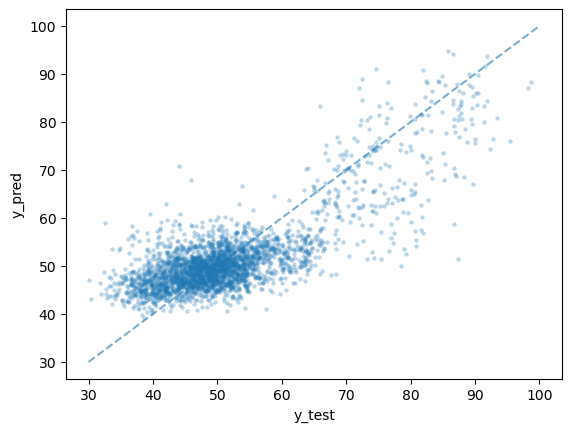

In [82]:
df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
ax = df.plot.scatter(x='y_test', y='y_pred', alpha=0.3, lw=0, s=10)
# sns.scatter(data=df, x='y_test', y='y_pred', alpha=0.6)

ax.plot([30,100], [30,100], '--', alpha=0.6)
plt.show()

<AxesSubplot: >

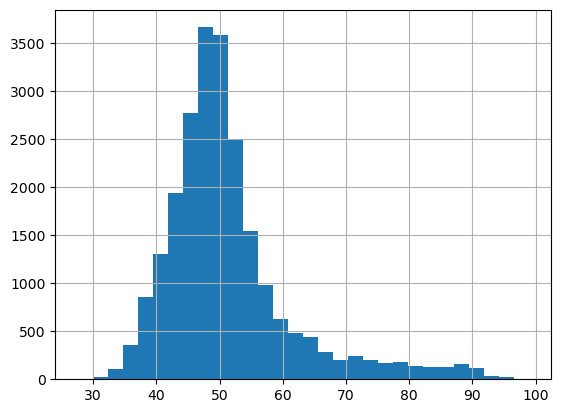

In [83]:
df_train.target.hist(bins=30)

- Ridge regerssion: spearman r: 0.6
- Kernel ridge regression (laplacian): spearman r: 0.625
- NN: mae = 4.7, mse = 38.4, rho = 0.67

### Build neural net on sequence embeddings

In [49]:
!pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 kB 6.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.0/264.0 kB 18.2 MB/s eta 0:00:00


In [58]:
import torch
from torch import nn
import pytorch_lightning as pl
import torchmetrics

In [97]:
class NeuralNetwork(pl.LightningModule):
    def __init__(self, initial_layer_size=1280):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(initial_layer_size, 512),
            nn.ReLU(),            
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits    

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x).squeeze(1)
        loss = nn.functional.mse_loss(y_pred, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x).squeeze(1)
        loss = nn.functional.mse_loss(y_pred, y)        
        self.log("val_loss", loss)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [109]:
def fit_model(X_train, y_train, X_valid):
    pl.seed_everything(42)
    model = NeuralNetwork(initial_layer_size=X_train.shape[1])
    
    trainer = pl.Trainer(
        # gpus=-1,
        # devices=0,
        accelerator="gpu",
        max_epochs=20,
        check_val_every_n_epoch=5)
    
    train_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_train).to(device), torch.Tensor(y_train).to(device))
    # valid_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_valid), torch.Tensor(y_valid))

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    # valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=False)

    trainer.fit(model, train_loader)
    
    return model

In [107]:
print(torch.Tensor(X_train).to(device).is_cuda)

True


In [85]:
y_pred.shape

(2897,)

In [95]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [110]:
model = fit_model(X_train, y_train, X_test)

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | linear_relu_stack | Sequential | 919 K 
-------------------------------------------------
919 K     Trainable params
0         Non-trainable params
919 K     Total params
3.676     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [112]:
y_pred

array([[40.97166 ],
       [58.974392],
       [49.53869 ],
       ...,
       [53.696003],
       [48.5216  ],
       [46.89811 ]], dtype=float32)

In [113]:
# y_pred = fit_predict(X_train, y_train, X_test).flatten()
# y_pred = model(torch.Tensor(X_test).to('cuda')[2].unsqueeze(1).detach().cpu()
y_pred = model(torch.Tensor(X_test)).detach().squeeze().numpy()

rho, _ = spearmanr(y_pred, y_test)  # spearman
mse = mean_squared_error(y_pred, y_test)  # Mean Squared Error
mae = (y_pred - y_test).abs().mean()  # Mean Absolute Error
print(f"{mae = :0.1f}, {mse = :0.1f}, {rho = :0.2f}")

mae = 4.7, mse = 38.4, rho = 0.67


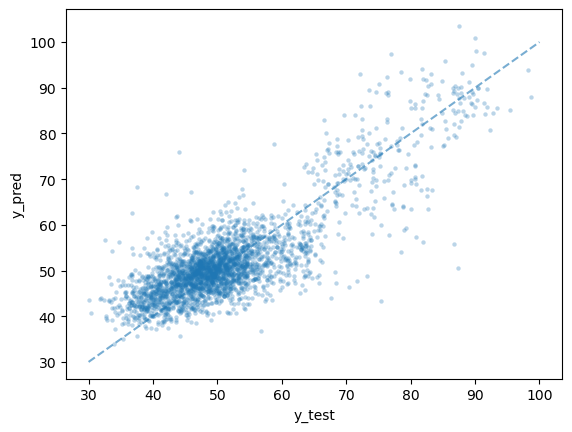

In [114]:
df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
ax = df.plot.scatter(x='y_test', y='y_pred', alpha=0.3, lw=0, s=10)
# sns.scatter(data=df, x='y_test', y='y_pred', alpha=0.6)

ax.plot([30,100], [30,100], '--', alpha=0.6)
plt.show()